# Training neural networks to characterize turbulence

Preamble: Run the cells below to import the necessary Python packages

<!-- *This notebook created by William Gilpin. Consult the [course website](https://www.wgilpin.com/cphy) for all content and [GitHub repository](https://github.com/williamgilpin/cphy) for raw files and runnable online code.* -->

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/talks/neural_networks_training.ipynb)

In [101]:
## Preamble / required packages
import numpy as np
np.random.seed(0)

## Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline

import warnings
## Comment this out to activate warnings
warnings.filterwarnings('ignore')


# plt.style.use("dark_background")

### Training a model

+ Given a model $f(\boldsymbol{x}; \boldsymbol{\theta})$ and a dataset $\{(\boldsymbol{x}_i, y_i)\}$, we want to find the parameters $\boldsymbol{\theta}$ that best describe the data.

+ Linear regression had an analytic equation for the weight matrix $\boldsymbol{\theta}$, turns out to minimize the least-squares cost function $J(\boldsymbol{\theta}) = \frac{1}{2} \sum_i (y_i - f(\boldsymbol{x}_i; \boldsymbol{\theta}))^2$.

+ Usually we aren't so lucky as to have an exactly solvable convex optimization problem

+ The next best thing is to have an optimization problem (possibly non-convex) where the loss is a smooth, differentiable function of the weights. In this case, we can use gradient descent and its variants

#### An aside: What if our problem is non-differentiable?

+ Brute force (try random parameters or grid search and see what gives the best result).

+ Genetic algorithms, reinforcement learning

+ Can attempt to use gradient descent, if we can construct a differentiable surrogate function for the true loss


## Predicting the Reynolds number of a turbulent flow

Our dataset will consist of snapshots of the velocity field of a turbulent flow. Each snapshot is labelled with the corresponding Reynolds number, which is a dimensionless number that characterizes the flow regime of a fluid. The higher the Reynolds number, the more turbulent the flow. Examples of low Reynolds number flows are the flow of honey around a spoon, or the motion of water around a swimming bacterium. Examples of high Reynolds number flows are the motion of air around an aircraft wing, or the flow created by the flapping of a bird's wing.

Because we are going to use large models for this problem, we will downsample the dataset substantially in order to ensure that we can train the model in a reasonable amount of time.

We will first implement a data loader that will fetch the dataset from a remote repository, perform standardization and downsampling, and then split the data into training and testing sets to help prevent overfitting.

Dataset size: X_train: (1920, 4096), y_train: (1920,)
Dataset size: X_test: (480, 4096), y_test: (480,)


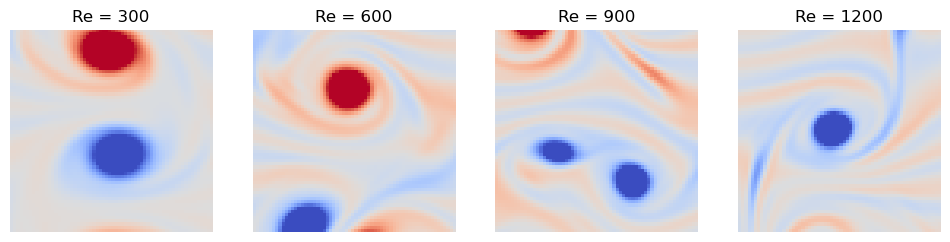

In [102]:
## Load the Reynold number regression dataset
import io, requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

class ReynoldsDataset:
    """
    Class to load the Reynolds number classification dataset
    
    Parameters:
        downsample (int): Factor by which to downsample the dataset
        split (float): Fraction of data to use for testing
        random_state (int): Random seed for reproducibility
    """

    def __init__(self, downsample=1, split=0.2, random_state=None):
        
        self.random_state = random_state
        url = "https://raw.githubusercontent.com/williamgilpin/cphy/main/resources/reynolds_data.npz"
        r = requests.get(url, timeout=30); r.raise_for_status()
        npz = np.load(io.BytesIO(r.content), allow_pickle=False)
        X = npz["X"]
        y = npz["y"]
        self.data_shape = (64, 64)


        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                            test_size=split, 
                                                            random_state=self.random_state
                                                            )

        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.X = np.vstack([X_train, X_test])
        self.y = np.hstack([y_train, y_test])

    def reshape(self, X):
        if len(X.shape) == 1:
            return X.reshape(self.data_shape)
        elif len(X.shape) == 2:
            return np.reshape(X, (X.shape[0], *self.data_shape))
        else:
            raise ValueError("X must be a 1D or 2D array")
    
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


dataset = ReynoldsDataset()

print(f"Dataset size: X_train: {dataset.X_train.shape}, y_train: {dataset.y_train.shape}")
print(f"Dataset size: X_test: {dataset.X_test.shape}, y_test: {dataset.y_test.shape}")

## plot examples of the dataset
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
for i, re in enumerate([300, 600, 900, 1200]):
    ax[i].imshow(dataset.reshape(dataset.X[dataset.y == re][0]), cmap='coolwarm', vmin=-.005, vmax=.005)
    ax[i].set_title(f"Re = {re}")
    ax[i].axis("off")
plt.show()


We can see that each of our data points is a flattened snapshot of the vorticity field of a turbulent flow, $\mathbf{x} \in \mathbb{R}^{D}$ with $D = 64^2 = 4096$ pixels. Each data point is labelled with the corresponding Reynolds number, $y \in \mathbb{R}$. We can first inspect our dataset qualitatively by plotting a few examples of each Reynolds number.

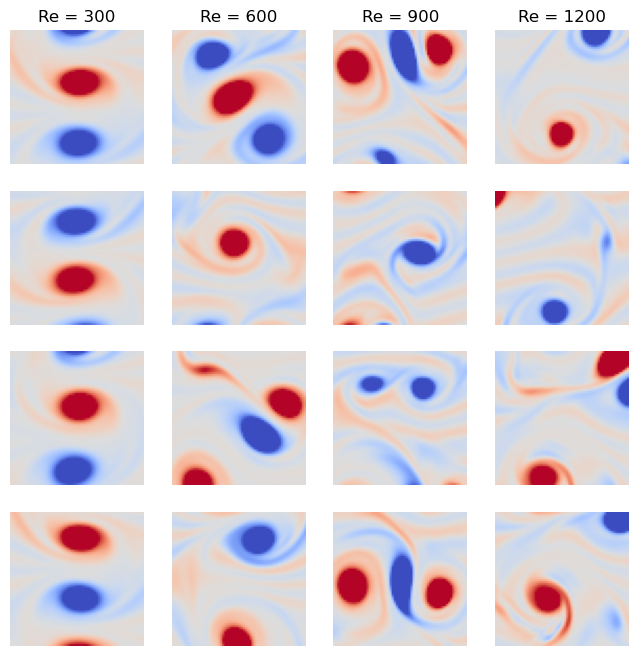

In [7]:
fig, ax = plt.subplots(4, 4, figsize=(8, 8))
for i, re in enumerate([300, 600, 900, 1200]):
    ax[i, 0].set_ylabel(f"Re = {re}")
    for j in range(4):
        ax[j, i].imshow(dataset.reshape(dataset.X[dataset.y == re][j]), cmap='coolwarm', vmin=-.005, vmax=.005)
        # ax[i, j].set_title(f"Re = {re}")
        ax[j, i].axis("off")
    ax[0, i].set_title(f"Re = {re}")
plt.show()

Our problem consists of a supervised regression problem: given a snapshot of the velocity field, predict the Reynolds number of the flow.

$$
    \hat{y} = f(\mathbf{x}; \boldsymbol{\theta})
$$

where $\mathbf{x} \in \mathbb{R}^{D}$ is the flattened vorticity field, and $\hat{y} \in \mathbb{R}$ is the predicted Reynolds number.

<br><br><br><br>

### Before fitting a model, check the data

We first perform an unsupervised embedding. We ignore the labels $y$ and inspect only the data $\mathbf{x}$. We can start by visualizing the full training dataset in a lower-dimensional space using principal component analysis (PCA).

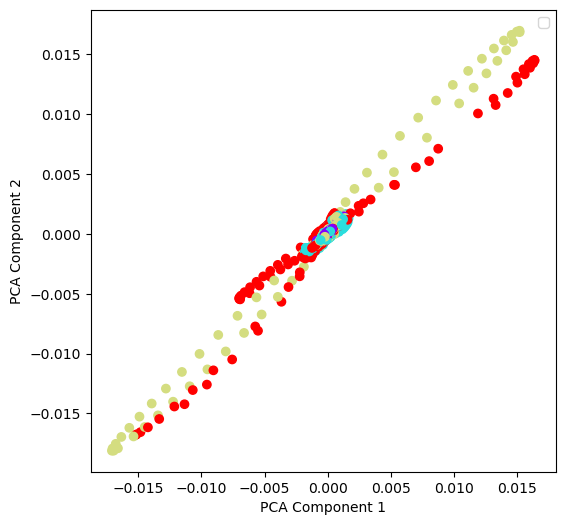

In [9]:
from sklearn.decomposition import PCA

## Perform PCA on the dataset
pca = PCA(n_components=2)
pca.fit(dataset.X_train)

## Plot the PCA components
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(dataset.X_train[:, 0], dataset.X_train[:, 1], c=dataset.y_train, cmap='rainbow')
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
plt.legend()

We see that the data is not linearly separable, so this is likely a non-trivial learning problem. We can also try using a non-linear embedding, such as t-SNE or UMAP, to see if either one better separates the data.

Text(0, 0.5, 'UMAP Component 2')

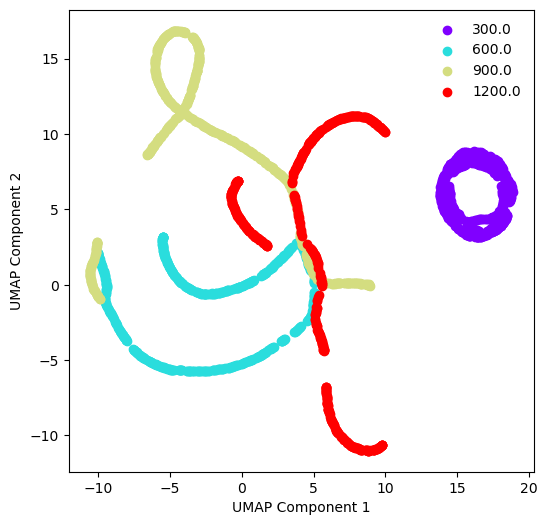

In [10]:
from umap import UMAP
umap = UMAP(n_components=2)
umap.fit(dataset.X_train)

## Plot the UMAP components
fig, ax = plt.subplots(figsize=(6, 6))
colors = plt.cm.rainbow(np.linspace(0, 1, len(np.unique(dataset.y_train))))
for re, color in zip(np.unique(dataset.y_train), colors):
    ax.scatter(umap.embedding_[dataset.y_train == re, 0], umap.embedding_[dataset.y_train == re, 1], c=color, label=re)
plt.legend(frameon=False)
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")



We can see that the low Reynolds number dataset ($Re = 300$) cleanly separates from the higher Reynolds number datasets. This tracks with our qualitative inspection of the dataset above, where the vortex street is clear at low Reynolds numbers, but quickly becomes turbulent at higher Reynolds numbers. 

We next check the balance of the dataset by inspecting the training labels $y$, and ignoring the data $\mathbf{x}$.

Fraction of class 1200.0: 0.239
Fraction of class 1200.0: 0.258
Fraction of class 1200.0: 0.257
Fraction of class 1200.0: 0.246


Text(0, 0.5, 'Number of Samples in Training Set')

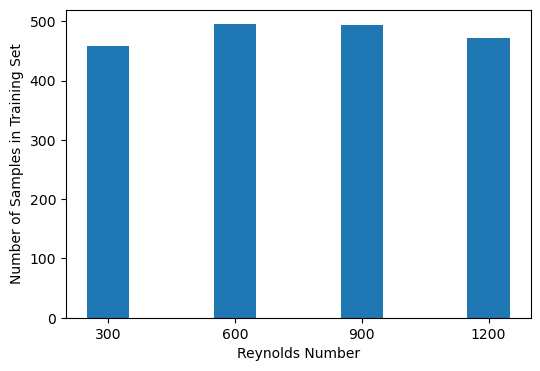

In [11]:
### Are the classes balanced?
class_ids = np.unique(dataset.y_train)
counts = list()
for id in class_ids:
    print(f"Fraction of class {re}: {np.mean(dataset.y_train == id):.3f}")
    counts.append(np.sum(dataset.y_train == id))

plt.figure(figsize=(6, 4))
plt.bar(class_ids, counts, width=100)
plt.xticks(class_ids)
plt.xlabel("Reynolds Number")
plt.ylabel("Number of Samples in Training Set")

### Generate baseline predictions

Since this is a regression problem, we will generate baseline predictions using a linear regression model. We suspect that the lack of linear separability of the data will lead to poor performance, but this helps us gain some intuition for what a "good" score should look like.

We will use the `sklearn` implementation of ridge regression. Instead of manually tuning the regularization parameter, we will use cross-validation to find the best value. `sklearn` has a built-in model that will perform this automatically, `RidgeCV`

In [12]:
from sklearn.linear_model import RidgeCV

## Train a linear model to predict the Reynolds number
model = RidgeCV()
model.fit(dataset.X_train, dataset.y_train)
y_pred = model.predict(dataset.X_test)

## Evaluate the model on the test set
print(f"Training set R^2: {model.score(dataset.X_train, dataset.y_train):.3f}")
print(f"Test set R^2: {model.score(dataset.X_test, dataset.y_test):.3f}")


Training set R^2: 0.306
Test set R^2: 0.276


# Let's try a neural network

Recall that a multilayer perceptron extends linear regression by adding non-linear activation functions between the linear transformation of the input and the output.

$$
  \hat{\mathbf{y}} = \sigma(\boldsymbol{\theta}_2 \sigma(\boldsymbol{\theta}_1 \mathbf{x}))
$$

where $\sigma$ is an elementwise function (such as the logistic function), $\boldsymbol{\theta}_1$ and $\boldsymbol{\theta}_2$ are trainable weight matrices, and $\mathbf{x}$ is a single input datapoint.

For our problem, $\mathbf{x} \in \mathbb{R}^{D}$, $D = 64^2 = 4096$ is the flattened velocity field, and $\hat{\mathbf{y}} \in \mathbb{R}$ is the predicted Reynolds number. While the output is a scalar here, this isn't a requirement of multilayer perceptron. The shapes of the weight matrices are $\boldsymbol{\theta}_1 \in \mathbb{R}^{M \times D}$ and $\boldsymbol{\theta}_2 \in \mathbb{R}^{1 \times M}$. While the input and output shapes are fixed by the problem, the number of neurons $M$ is a hyperparameter. This is sometimes called the "width" of the network, or the "number of hidden units" of the network.

We will use `scikit-learn`'s own implementation of a multi-layer perceptron (MLP). This will handle fitting the values of the weight matrices $\boldsymbol{\theta}_1$ and $\boldsymbol{\theta}_2$ that minimize the model's prediction across the training set. Behind the scenes, it will handle the forward and backward passes, and the updates to the weight matrices. The objective function that this model minimizes is the mean-squared error between the predicted and true labels across the training set:
$$
  \mathcal{L}(\boldsymbol{\theta}_1, \boldsymbol{\theta}_2) = \frac{1}{2} \sum_{i=1}^N (\hat{y}_i - y_i)^2
$$
where $N$ is the number of datapoints in the training set, $\hat{y}_i$ is the model's predicted Reynolds number for the $i^{th}$ datapoint (which depends on the current values of the weight matrices $\boldsymbol{\theta}_1$ and $\boldsymbol{\theta}_2$), and $y_i$ is the true Reynolds number.



In [103]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(
    hidden_layer_sizes=(10, 10),  # The network architecture, number of neurons in each hidden layer
    activation='relu', # The elementwise nonlinearity applied elementwise to the output of matrix multiplication
    solver='adam', # The optimizer that we use to update the weights
    learning_rate='constant', # The learning rate schedule for the optimizer
    learning_rate_init=0.001, # The initial learning rate
    max_iter=1000, # The maximum number of iterations
    random_state=0, # The random seed for reproducibility
    batch_size=32 # The number of samples used to compute the gradient at each step
)
# mlp = MLPRegressor()

We can see that the constructor specifies the network architecture and several hyperparameters that affect the training process: 

+ The "Adam" optimizer is a variant of gradient descent that uses adaptive learning rates and momentum. This is used to determine the updates to the weight matrices.

+ The "relu" activation function is a non-linear function $\sigma(x) = \max(0, x)$ that is more robust to vanishing gradients than the logistic function

+ The "batch size" is the number of samples used to compute the gradient at each step. This is a compromise between using the full dataset (which is slow) and using a single sample (which is noisy). 

+ The "epoch" is the number of times the entire dataset is used to compute the gradient.

Training set R^2 score: 0.992112
Test set R^2 score: 0.986656


Text(0, 0.5, 'Predicted Reynolds number')

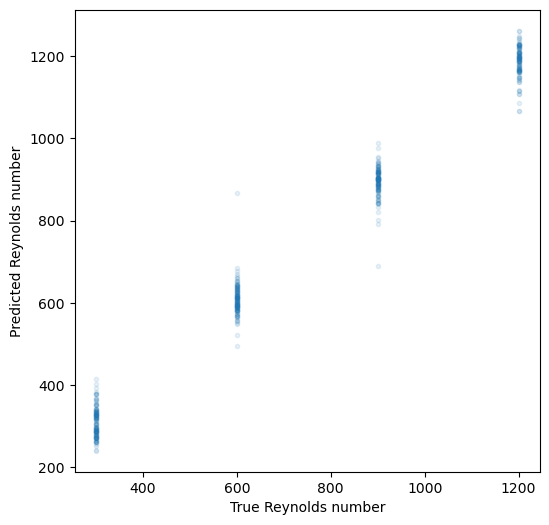

In [104]:
# Fit the model to the training data.
mlp.fit(dataset.X_train, dataset.y_train)

# Generate predictions on the test set.
y_test_pred = mlp.predict(dataset.X_test)

## Score using R^2
print("Training set R^2 score: %f" % mlp.score(dataset.X_train, dataset.y_train))
print("Test set R^2 score: %f" % mlp.score(dataset.X_test, dataset.y_test))

plt.figure(figsize=(6, 6))
plt.plot(dataset.y_test, y_test_pred, '.', alpha=0.1)
plt.xlabel("True Reynolds number")
plt.ylabel("Predicted Reynolds number")

## What about other supervised learning models?

There are many supervised learning models besides variants of linear regression and neural networks. For example, random forests and their generalization, gradient boosted forests, use a different set of models based on ensembling to perform classification and regression. 

In [21]:
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LassoCV

for model in [HistGradientBoostingRegressor(), RandomForestRegressor()]:

    # Fit the model to the data.
    model.fit(dataset.X_train, dataset.y_train)

    # Generate predictions on the test set.
    y_test_pred = model.predict(dataset.X_test)

    ## Score using R^2
    print(f"{model.__class__.__name__}")
    print("Training set R^2 score: %f" % model.score(dataset.X_train, dataset.y_train))
    print("Test set R^2 score: %f" % model.score(dataset.X_test, dataset.y_test))
    print("\n")

HistGradientBoostingRegressor
Training set R^2 score: 0.999850
Test set R^2 score: 0.990048


RandomForestRegressor
Training set R^2 score: 0.997939
Test set R^2 score: 0.988035




In [105]:
dataset.X_train.shape

(1920, 4096)

# How do we train a multilayer perceptron?



Given a model 
$$
    \hat{y} = \sigma(\boldsymbol{\theta}_2 \sigma(\boldsymbol{\theta}_1 \mathbf{x}))
$$
and an objective function
$$
    \mathcal{L}(\boldsymbol{\theta}_1, \boldsymbol{\theta}_2) = \frac{1}{2} \sum_{i=1}^N (\hat{y}_i - y_i)^2
$$

where the sum indexes into the $N$ training datapoints. Each training point $\mathbf{x}$ has a known true label $y$. We can update the weights with gradient descent. For our two-layer network, our relevant gradients are

$$
    \boldsymbol{\theta}_1 \leftarrow \boldsymbol{\theta}_1 - \eta \frac{\partial \mathcal{L}}{\partial \boldsymbol{\theta}_1}
$$
$$
    \boldsymbol{\theta}_2 \leftarrow \boldsymbol{\theta}_2 - \eta \frac{\partial \mathcal{L}}{\partial \boldsymbol{\theta}_2}
$$

where $\eta$ is the learning rate. Gradient descent operates elementwise on the weights. Fortunately, the gradient of a scalar objective with respect to a tensor of a given shape is a tensor of the same shape.
Given a training set with $N$ examples, we usually take the average of the gradient computed over the $N$ examples.

<br><br><br><br><br><br>



### Taking gradients defines a computational graph

Let's start by revisiting how we optimize in low dimensions. Suppose we wanted to take the gradient of the double well potential

$$
    V(x) = x^4 - 2 x^2
$$

We can find the gradient analytically by taking the derivative
$$
    \frac{\partial V}{\partial x} = 4 x^3 - 4 x
$$

In [106]:
def double_well(x):
    """Double well potential function"""
    return x**4 - 2*x**2

def double_well_grad(x):
    """Derivative of double well potential function"""
    return 4*x**3 - 4*x

print(double_well(0.12132987))
print(double_well_grad(0.12132987))

-0.029225168711847025
-0.4781751223381389


We implicitly performed several subcomputations to do this. Let's write out these functions in terms of basic computational steps.


Given an $x$, computing $V(x)$ (the forward evaluation, or *forward pass*) can be broken up into

$$
    V(x) = x^4 - 2 x^2
$$
$$
h_1 = x^4
$$
$$
h_2 = 2 x^2
$$
$$
V = h_1 - h_2
$$



Now, given $V$, we want to compute $\frac{\partial V}{\partial x}$ (the backward evaluation, or *backward pass*). We can break this up into

$$
    \frac{\partial V}{\partial x} = 4 x^3 - 4 x
$$
$$
g_1 = 4 x
$$
$$
g_2 = 4 x^3
$$
$$
g_3 = -1
$$
$$
\frac{\partial V}{\partial x} = g_2 + g_3 g_1
$$

In [107]:
def double_well_primitive(x):
    """Decompose the double well calculation into primitive operations"""
    h1a = x**4
    h1b = 2*x**2
    h2 = h1a - h1b
    return h2

def double_well_primitive_grad(x):
    """Decompose the double well gradient calculation into primitive operations"""
    dh2dh1a = 1
    dh2dh1b = -1
    dh1adx = 4*x**3
    dh1bdx = 4*x
    dh2dx = dh2dh1a * dh1adx + dh2dh1b * dh1bdx
    return dh2dx

print(double_well_primitive(0.12132987))
print(double_well_primitive_grad(0.12132987))

-0.029225168711847025
-0.4781751223381389


## Backpropagation through a multilayer perceptron

### Forward pass

When a trained neural network is given an input $\mathbf{x}$, it computes an output $\hat{\mathbf{y}}$ by passing the input through a series of layers. Each layer is a linear transformation followed by a non-linear function. For example, a two-layer network is given by

$$
    \hat{y} = \sigma(\boldsymbol{\theta}_2 \sigma(\boldsymbol{\theta}_1 \mathbf{x}))
$$
for concreteness, we will use the sigmoid nonlinearity $\sigma(x) = \frac{1}{1 + e^{-x}}$. This model takes an input $\mathbf{x} \in \mathbb{R}^D$ and performs a matrix multiplication with $\boldsymbol{\theta}_1 \in \mathbb{R}^{H_1 \times D}$ to produce a hidden representation $\mathbb{R}^{H_1}$. The nonlinearity is then applied elementwise to produce a hidden representation with the same shape $\mathbf{h}_1 \in \mathbb{R}^{H_1}$. A matrix multiplication with $\boldsymbol{\theta}_2 \in \mathbb{R}^{1 \times H_1}$ is then used to contract the hidden representation into a single output, followed by a sigmoid nonlinearity to produce the final prediction $\hat{y} \in \mathbb{R}$.

We start by breaking this into single steps

$$
    \mathbf{h}_1^{u} = \boldsymbol{\theta}_1 \cdot \mathbf{x} \in \mathbb{R}^{H_1}
$$

$$
\mathbf{h}_1 = \sigma(\mathbf{h}_1^{u}) \in \mathbb{R}^{H_1}
$$

$$
    h_2^{u} = \boldsymbol{\theta}_2 \cdot \mathbf{h}_1 \in \mathbb{R}
$$

$$
    \hat{y} = \sigma(h_2^{u}) \in \mathbb{R}
$$


In [108]:

sigma = lambda x: 1 / (1 + np.exp(-x)) # Logistic sigmoid
    
loss = lambda y_hat, y_true: (y_hat - y_true)**2


class MLP:

    def __init__(self, input_dim, hidden_dim, output_dim=1):

        ## Randomly initialize the weights
        self.theta1 = np.random.randn(hidden_dim, input_dim)
        self.theta2 = np.random.randn(output_dim, hidden_dim)
        
        self.cache = {}
        self.cache["x"] = None
        self.cache["h1u"] = None
        self.cache["h1"] = None
        self.cache["h2u"] = None
        self.cache["y"] = None

    def forward(self, x):

        ## Calculate the forward pass
        h1u = self.theta1 @ x
        h1 = sigma(h1u)
        h2u = self.theta2 @ h1
        yhat = sigma(h2u)

        ## Cache the intermediate values
        self.cache["x"] = x
        self.cache["h1u"] = h1u
        self.cache["h1"] = h1
        self.cache["h2u"] = h2u
        self.cache["y"] = y

        return yhat
    
    def __call__(self, x):
        return self.forward(x)
        


In [111]:
x = dataset.X[0]
x.shape
y = dataset.y[0]
y

np.float64(1200.0)

In [113]:
x = dataset.X[0]
y = dataset.y[0]

print("Input shape: ", x.shape)
print("Label: ", y)

mlp = MLP(x.shape[0], 25)
yhat = mlp(x)

print("\nPrediction: ", y_hat)
print("Loss: ", loss(y_hat, y))





Input shape:  (4096,)
Label:  1200.0

Prediction:  [0.97752657]
Loss:  [1437654.89179164]


### Backward pass

Suppose we pass an input $\mathbf{x} \in \mathbb{R}^D$ and get an output $\hat{y} \in \mathbb{R}$, and we know the true output is $y \in \mathbb{R}$.

If we are using the mean-squared error loss function, then for a single training example $\mathbf{y}$, the loss $\mathcal{L} \in \mathbb{R}$ is

$$
    \mathcal{L} = \frac{1}{2} (\hat{y} - y)^2
$$

We want to update all the parameters $\boldsymbol{\theta}_1$ and $\boldsymbol{\theta}_2$ to minimize this loss. To calculate $\frac{\partial \mathcal{L}}{\partial \boldsymbol{\theta}_2} \in \mathbb{R}^{M \times H_2}$, we need to use the chain rule,

$$
\frac{\partial \mathcal{L}}{\partial \boldsymbol{\theta}_2} = \frac{\partial \mathcal{L}}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial \mathbf{h}_2^{u}} \frac{\partial \mathbf{h}_2^{u}}{\partial \boldsymbol{\theta}_2}
$$

In a *reverse-mode* chain rule evaluation, we can solve this sequence from left-to-right. We start with the scalar term. Since the loss is a scalar, and both the prediction and the true label are scalars, the gradient is a scalar.

$$
\frac{\partial \mathcal{L}}{\partial \hat{y}} = 2(\hat{y} - y)
$$

Next, we need to compute the gradient of the sigmoid nonlinearity with respect to its input. Since the sigmoid nonlinearity is applied elementwise to the scalar input $h_2^{u}$, this is a scalar as well. A useful identity for the sigmoid nonlinearity is $\sigma'(x) = \sigma(x) (1 - \sigma(x))$.

$$
    \frac{\partial \hat{y}}{\partial h_2^{u}} = \hat{y} (1 - \hat{y})
$$

Finally, we need to compute the gradient of the linear transformation with respect to the weight matrix. Since the input to the linear transformation is a vector, the gradient is a row vector.

$$
    \frac{\partial h_2^{u}}{\partial \boldsymbol{\theta}_2} = \mathbf{h}_1^\top
$$

Putting this all together,

$$
\frac{\partial \mathcal{L}}{\partial \boldsymbol{\theta}_2} = 2(\hat{y} - y) \hat{y} (1 - \hat{y}) \mathbf{h}_1^\top
$$

Notice how we actually traversed the network *backwards*, starting with the gradient of the last evaluation we performed during the forward pass. In order to update $\boldsymbol{\theta}_2$, we need to know both the output of the forward pass $\hat{y}$ and the intermediate hidden representation $\mathbf{h}_1$. Fortunately, we cached these values during the forward pass.


In [115]:
# def mlp_backward(y_hat, y, h1, theta2):
#     """Backward pass for a two-layer MLP"""
#     dL_dyhat = y_hat - y
#     dyhat_dh2u = y_hat * (1 - y_hat)
#     dh2u_dtheta2 = h1
#     dL_dtheta2 = dL_dyhat * dyhat_dh2u * dh2u_dtheta2
#     return dL_dtheta2

# grad_theta2 = mlp_backward(y_hat, y, h1, theta2)


class MLP_backward(MLP):

    def backward_theta2(self, y, y_hat):
        dL_dyhat = y_hat - y
        dyhat_dh2u = y_hat * (1 - y_hat)
        dh2u_dtheta2 = self.cache["h1"]
        dL_dtheta2 = dL_dyhat * dyhat_dh2u * dh2u_dtheta2
        return dL_dtheta2


mlp = MLP_backward(x.shape[0], 25)
yhat = mlp(x)

mlp.backward_theta2(y, yhat)


array([-117.60890157, -120.67614512, -116.97751855, -121.16666731,
       -121.298501  , -116.70603   , -123.52980177, -125.71479547,
       -115.75114634, -122.82003035, -114.34373859, -118.55023403,
       -116.87187517, -120.66398211, -114.08485612, -114.98122104,
       -123.56222141, -115.22779076, -104.53377703, -117.69677624,
       -127.77116637, -123.26174983, -118.22744413, -133.93988935,
       -126.67922007])

# Backpropagation is the chain rule on a computation graph


<img src="../resources/backprop1.png" width="750">
<img src="../resources/backprop2.png" width="750">

*Diagrams from [UW CSE599W lecture notes](https://dlsys.cs.washington.edu/pdf/lecture4.pdf)*


We can now compute the gradient for the first layer.

$$
\frac{\partial \mathcal{L}}{\partial \boldsymbol{\theta}_1} = 

\frac{\partial \mathcal{L}}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial h_2^{u}} \frac{\partial h_2^{u}}{\partial \mathbf{h}_1} \frac{\partial \mathbf{h}_1}{\partial \mathbf{h}_1^{u}} \frac{\partial \mathbf{h}_1^{u}}{\partial \boldsymbol{\theta}_1}
$$

We can find the first few terms as above. For the term $\frac{\partial \mathbf{h}_1}{\partial \mathbf{h}_1^{u}}$, we are taking the gradient of an elementwise operation over a vector, and so this returns a vector.
<!-- 
$$
    \frac{\partial \mathcal{L}}{\partial \mathbf{h}_2^{u}} = (\hat{\mathbf{y}} - \mathbf{y}) \odot \hat{\mathbf{y}} (1 - \hat{\mathbf{y}}) \boldsymbol{\theta}_2^\top
$$ -->

$$
    \frac{\partial \mathbf{h}_1^{u}}{\partial \mathbf{h}_1} = \mathbf{h}_1 (1 - \mathbf{h}_1) \in \mathbb{R}^{H_1}
$$

where the product is taken elementwise.
<!-- 
$$
\frac{\partial \mathbf{h}_1}{\partial \mathbf{h}_1^{u}} = \mathbf{h}_1^{u} (1 - \mathbf{h}_1^{u})
$$

$$
\frac{\partial \mathbf{h}_1^{u}}{\partial \boldsymbol{\theta}_1} = \mathbf{x}^\top
$$ -->

Putting this all together,

$$
\frac{\partial \mathcal{L}}{\partial \boldsymbol{\theta}_1} = 2(\hat{y} - y) \hat{y} (1 - \hat{y}) \left(\boldsymbol{\theta}_2^\top \odot \mathbf{h}_1 (1 - \mathbf{h}_1)\right) \mathbf{x}^\top
$$

where $\odot$ denotes the elementwise product. The parenthetical term corresponds to a column vector of shape $H_1$. Since $\mathbf{x}$ appears as row vector of shape $D$, the gradient is a matrix of shape $H_1 \times D$.




<!-- 
These left-right rules are also used in the derivation of the linear regression pseudoinverse global solution.

Additionally, we should remember the chain rule for derivatives:
$$
\frac{\partial\mathbf{A}(u) \mathbf{B}(u)}{\partial u} = \frac{\partial\mathbf{A}(u)}{\partial u} \mathbf{B}(u) + \mathbf{A}(u) \frac{\partial\mathbf{B}(u)}{\partial u}
$$ -->


In [118]:

def backward_theta1(self, y, y_hat):
    """
    Args:
        y (float): True target (scalar).
        y_hat (float): Model prediction (scalar).

    Returns:
        (ndarray): Gradient dL/dtheta1 with shape (hidden_dim, input_dim).
    """
    x = self.cache["x"]  # must be cached during forward

    h1 = self.cache["h1"]                  # (hidden_dim,)
    theta2 = self.theta2.reshape(-1)       # (hidden_dim,)

    dL_dyhat = 2.0 * (y_hat - y)           # derivative of (y_hat - y)^2
    dyhat_dh2u = y_hat * (1 - y_hat)       # σ'(h2u)
    upstream = dL_dyhat * dyhat_dh2u       # scalar

    delta1 = upstream * theta2 * h1 * (1 - h1)  # (hidden_dim,)
    dL_dtheta1 = np.outer(delta1, x)            # (hidden_dim, input_dim)
    return dL_dtheta1


## Dynamic binding to an existing object
MLP_backward.backward_theta1 = backward_theta1

mlp = MLP_backward(x.shape[0], 25)
yhat = mlp(x)

mlp.backward_theta1(y, yhat).shape


(25, 4096)

Notice that the gradient of $\boldsymbol{\theta}_1$ is the same shape as the parameter itself, and so gradient descent can be applied elementwise.

### Some things to note when performing the backwards pass

+ Several of the "intermediate" values we computed during the forward pass re-appear when we perform the backwards pass. Because we cached these values, then we don't have to recompute them during the backward pass. 

+ Notice that when we compute the "forward" pass we start with the innermost portion of the function composition, and then work our way out. For the backwards pass, we start with the outermost portion of the function composition, and work our way in. 

+ Notice that the sigmoid function's derivative $\sigma'(x) = \sigma(x) (1 - \sigma(x))$ can be written as a function purely of its output $\sigma(x)$. This is a common pattern in autodiff. 

+ In order to keep track of indicies and transposes, it helps to think about the dimensions of the input/output of each primitive operation.

+ It's useful to remember the some [rules for matrix derivatives:](https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf)

$$
\frac{\partial\mathbf{A} \mathbf{B}}{\partial \mathbf{A}} = \mathbf{B}^\top, \qquad
\frac{\partial\mathbf{A} \mathbf{B}}{\partial \mathbf{B}} = \mathbf{A}
$$

In [134]:

sigma = lambda x: 1 / (1 + np.exp(-x))
    
loss = lambda y_hat, y_true: (y_hat - y_true)**2


class MLP:

    def __init__(self, input_dim, hidden_dim, output_dim=1):

        ## Randomly initialize the weights
        self.theta1 = 0.01*np.random.randn(hidden_dim, input_dim)
        self.theta2 = 0.01*np.random.randn(output_dim, hidden_dim)
        
        self.cache = {}
        self.cache["x"] = None
        self.cache["h1u"] = None
        self.cache["h1"] = None
        self.cache["h2u"] = None
        self.cache["y"] = None

    def forward(self, x):

        ## Calculate the forward pass
        h1u = self.theta1 @ x
        h1 = sigma(h1u)
        h2u = self.theta2 @ h1
        yhat = sigma(h2u)

        ## Cache the intermediate values
        self.cache["x"] = x
        self.cache["h1u"] = h1u
        self.cache["h1"] = h1
        self.cache["h2u"] = h2u
        self.cache["y"] = y

        return yhat

    def backward_theta1(self, y, y_hat):
        """
        Args:
            y (float): True target (scalar).
            y_hat (float): Model prediction (scalar).

        Returns:
            (ndarray): Gradient dL/dtheta1 with shape (hidden_dim, input_dim).
        """
        x = self.cache["x"]  # must be cached during forward

        h1 = self.cache["h1"]                  # (hidden_dim,)
        theta2 = self.theta2.reshape(-1)       # (hidden_dim,)

        dL_dyhat = 2.0 * (y_hat - y)           # derivative of (y_hat - y)^2
        dyhat_dh2u = y_hat * (1 - y_hat)       # σ'(h2u)
        upstream = dL_dyhat * dyhat_dh2u       # scalar

        delta1 = upstream * theta2 * h1 * (1 - h1)  # (hidden_dim,)
        dL_dtheta1 = np.outer(delta1, x)            # (hidden_dim, input_dim)
        return dL_dtheta1

    def backward_theta2(self, y, y_hat):
        dL_dyhat = y_hat - y
        dyhat_dh2u = y_hat * (1 - y_hat)
        dh2u_dtheta2 = self.cache["h1"]
        dL_dtheta2 = dL_dyhat * dyhat_dh2u * dh2u_dtheta2
        return dL_dtheta2

    def backward(self, y, y_hat):
        dL_dtheta1 = self.backward_theta1(y, y_hat)
        dL_dtheta2 = self.backward_theta2(y, y_hat)
        return dL_dtheta1, dL_dtheta2
    
    def __call__(self, x):
        return self.forward(x)

In [121]:
mlp = MLP(x.shape[0], 25)

In [137]:
mlp = MLP(x.shape[0], 25)


learning_rate = 0.1
all_losses = []
all_preds = []
for _ in range(10):
    yhat = mlp(x)
    dL_dtheta1, dL_dtheta2 = mlp.backward(y, yhat)

    mlp.theta1 -= learning_rate * dL_dtheta1
    mlp.theta2 -= learning_rate * dL_dtheta2


    all_losses.append(loss(yhat, y))
    all_preds.append(yhat)




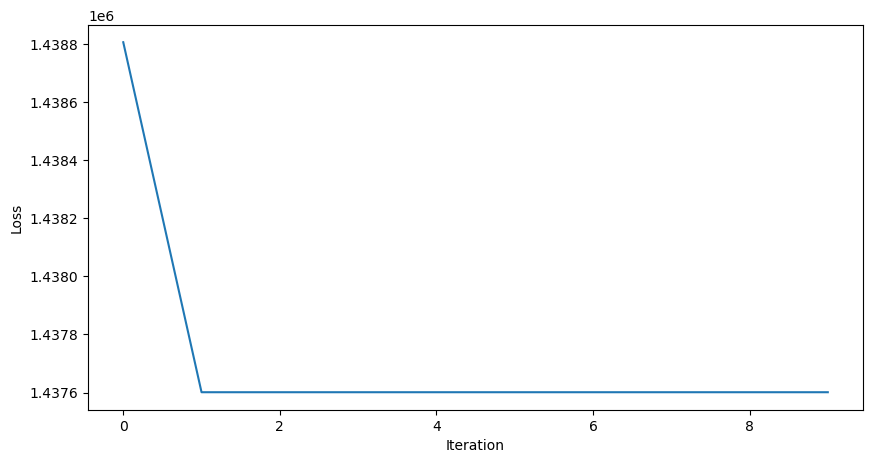

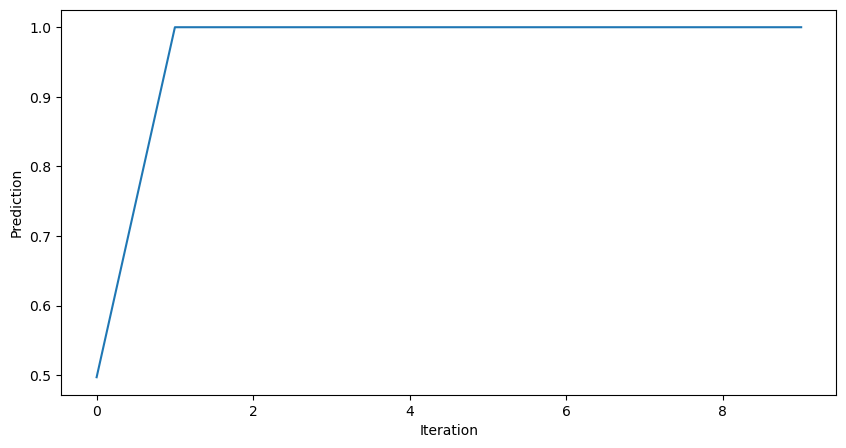

In [138]:
plt.figure(figsize=(10, 5))
plt.plot(all_losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")


plt.figure(figsize=(10, 5))
plt.plot(all_preds)
plt.xlabel("Iteration")
plt.ylabel("Prediction")
plt.show()





This improves the model, but it's still not very good. Why does the prediction $\hat{y}$ plateau at 1.0? Let's try implementing our model with a different activation function, the RELU.

In [141]:
sigma = lambda x: np.maximum(0, x) # ReLU
    
loss = lambda y_hat, y_true: (y_hat - y_true)**2


class MLP:

    def __init__(self, input_dim, hidden_dim, output_dim=1):

        ## Randomly initialize the weights
        self.theta1 = 0.01*np.random.randn(hidden_dim, input_dim)
        self.theta2 = 0.01*np.random.randn(output_dim, hidden_dim)
        
        self.cache = {}
        self.cache["x"] = None
        self.cache["h1u"] = None
        self.cache["h1"] = None
        self.cache["h2u"] = None
        self.cache["y"] = None

    def forward(self, x):

        ## Calculate the forward pass
        h1u = self.theta1 @ x
        h1 = sigma(h1u)
        h2u = self.theta2 @ h1
        yhat = sigma(h2u)

        ## Cache the intermediate values
        self.cache["x"] = x
        self.cache["h1u"] = h1u
        self.cache["h1"] = h1
        self.cache["h2u"] = h2u
        self.cache["y"] = y

        return yhat

    def backward_theta1(self, y, y_hat):
        """
        Args:
            y (float): True target (scalar).
            y_hat (float): Model prediction (scalar).

        Returns:
            (ndarray): Gradient dL/dtheta1 with shape (hidden_dim, input_dim).
        """
        x = self.cache["x"]  # must be cached during forward

        h1 = self.cache["h1"]                  # (hidden_dim,)
        theta2 = self.theta2.reshape(-1)       # (hidden_dim,)

        dL_dyhat = 2.0 * (y_hat - y)           # derivative of (y_hat - y)^2
        dyhat_dh2u = (yhat > 0).astype(float)  # σ'(h2u)
        upstream = dL_dyhat * dyhat_dh2u       # scalar

        delta1 = upstream * theta2 * (h1 > 0).astype(float)
        dL_dtheta1 = np.outer(delta1, x)            # (hidden_dim, input_dim)
        return dL_dtheta1

    def backward_theta2(self, y, y_hat):
        dL_dyhat = y_hat - y
        dyhat_dh2u = (yhat > 0).astype(float)
        dh2u_dtheta2 = self.cache["h1"]
        dL_dtheta2 = dL_dyhat * dyhat_dh2u * dh2u_dtheta2
        return dL_dtheta2

    def backward(self, y, y_hat):
        dL_dtheta1 = self.backward_theta1(y, y_hat)
        dL_dtheta2 = self.backward_theta2(y, y_hat)
        return dL_dtheta1, dL_dtheta2
    
    def __call__(self, x):
        return self.forward(x)

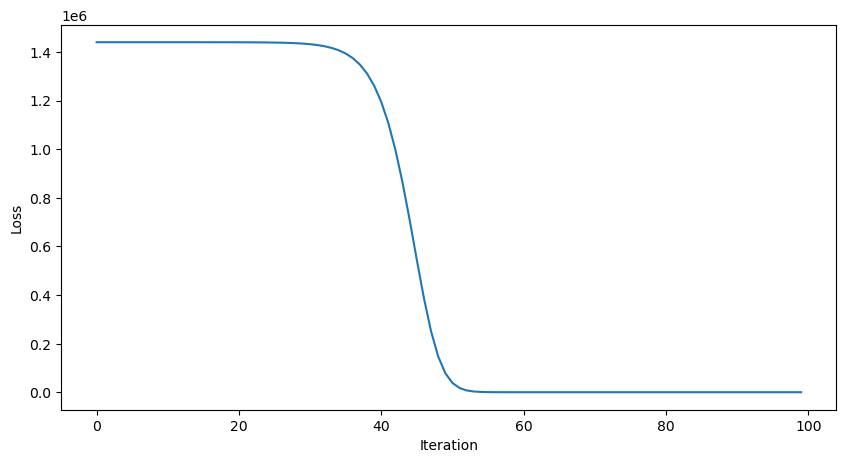

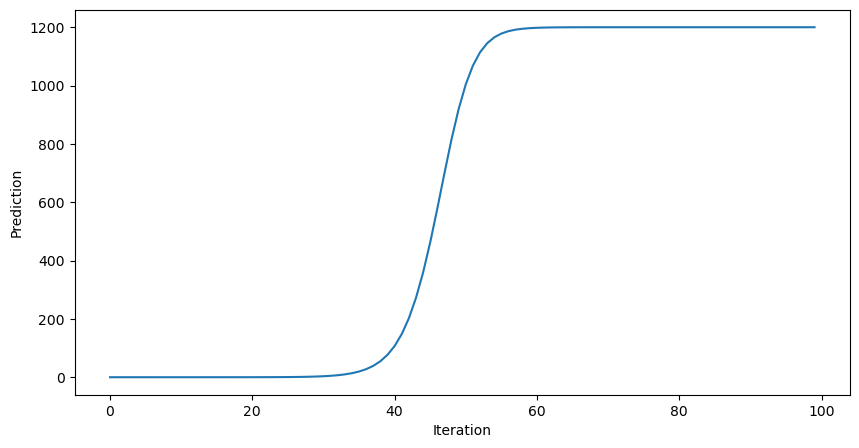

In [142]:
mlp = MLP(x.shape[0], 25)


learning_rate = 0.001
all_losses = []
all_preds = []
for _ in range(100):
    yhat = mlp(x)
    dL_dtheta1, dL_dtheta2 = mlp.backward(y, yhat)

    mlp.theta1 -= learning_rate * dL_dtheta1
    mlp.theta2 -= learning_rate * dL_dtheta2


    all_losses.append(loss(yhat, y))
    all_preds.append(yhat)


plt.figure(figsize=(10, 5))
plt.plot(all_losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")


plt.figure(figsize=(10, 5))
plt.plot(all_preds)
plt.xlabel("Iteration")
plt.ylabel("Prediction")
plt.show()






This looks good, but how well does our trained model perform on unseen data?

In [146]:
print(mlp(dataset.X_train[0]))
print(dataset.y_train[0])

[1199.99999999]
1200.0


In [145]:
print(mlp(dataset.X_test[0]))
print(dataset.y_test[0])

[42.87352604]
1200.0


Let's modify our training loop to exploit that we have many datapoints. At each iteration, we pass *multiple* datapoints through the network, and compute the average gradient of the loss with respect to the weights. This is called **mini-batch gradient descent**. The size of the batch is a hyperparameter. Because we select a random batch of datapoints, the dynamics in weight space are stochastic.

In [147]:
dataset.X_train.shape

(1920, 4096)

In [148]:
x_batch = dataset.X_train[np.random.randint(0, dataset.X_train.shape[0], size=100)]

In [158]:
np.random.randint(0, dataset.X_train.shape[0], size=500)

array([1309,  391, 1711, 1250,   99,  289,  826, 1376,  635, 1766, 1707,
       1697, 1340,  945,  419, 1006,   70,  840, 1711,  222, 1079,  653,
         73,  998,  513,   78,  490,  534, 1263,  991, 1199, 1530, 1821,
       1775,  547,  583, 1211,  407,  944,  391,  934,  328, 1356,  851,
       1917,  944, 1777,  742, 1668, 1483,  694,  886,  514,  504, 1269,
       1695,  794,  407,  192,  664, 1425, 1218,  697, 1064,  141, 1815,
        321, 1769, 1866, 1465,  633, 1646,  764, 1294, 1619,  542,  638,
        629, 1060, 1752,  463, 1642, 1677, 1363, 1007,  183,  509,  583,
        680,   10, 1416,  748, 1276, 1481,  442, 1357,  124,  742, 1340,
        579, 1732, 1843,  736,  548,  397,  922, 1869, 1108,  659, 1291,
        494,  375, 1610, 1907, 1022, 1002,  355, 1822,  771,  900, 1647,
        562,  745, 1381,   60, 1113, 1520, 1203, 1622,  845, 1308, 1506,
       1673,  367, 1237,  156,   58, 1186, 1191,  191, 1789, 1202, 1396,
        936,  688, 1770, 1398, 1357,  139,  716, 10

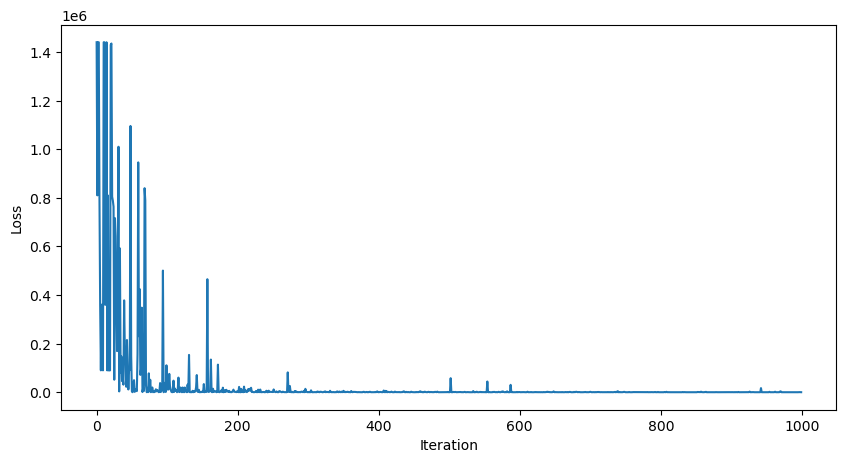

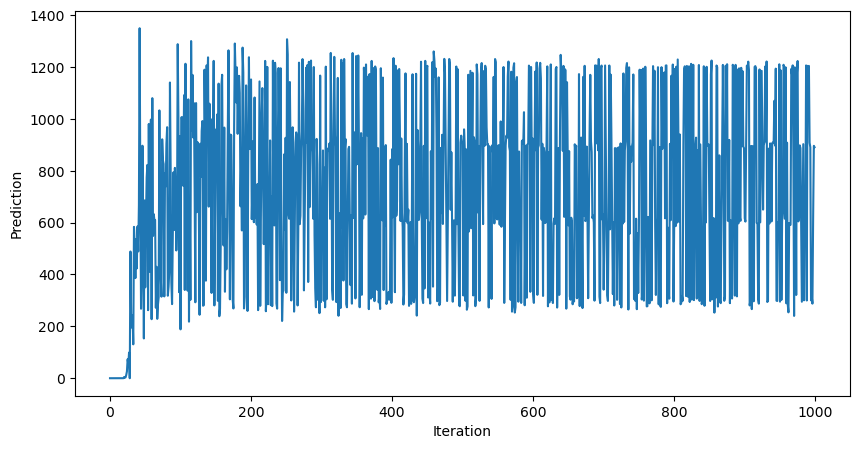

In [ ]:
mlp = MLP(dataset.X_train.shape[1], 25)


learning_rate = 0.01
all_losses = []
all_preds = []
for _ in range(1000):

    ## Randomly sample a batch of data from the training set
    batch_indices = np.random.randint(0, dataset.X_train.shape[0], size=100)
    x_batch = dataset.X_train[batch_indices]
    y_batch = dataset.y_train[batch_indices]
    all_dL_dtheta1, all_dL_dtheta2 = [], []
    all_yhat = []
    for x, y in zip(x_batch, y_batch):
        yhat = mlp(x)
        dL_dtheta1, dL_dtheta2 = mlp.backward(y, yhat)
        all_yhat.append(yhat)
        all_dL_dtheta1.append(dL_dtheta1)
        all_dL_dtheta2.append(dL_dtheta2)

    yhat_batch = np.array(all_yhat)
    dL_dtheta1_batch = np.mean(all_dL_dtheta1, axis=0)   
    dL_dtheta2_batch = np.mean(all_dL_dtheta2, axis=0)

    mlp.theta1 -= learning_rate * dL_dtheta1_batch
    mlp.theta2 -= learning_rate * dL_dtheta2_batch


    all_losses.append(loss(yhat, y))


plt.figure(figsize=(10, 5))
plt.plot(all_losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")


plt.figure(figsize=(10, 5))
plt.plot(all_preds)
plt.xlabel("Iteration")
plt.ylabel("Prediction")
plt.show()






In [160]:
print(mlp(dataset.X_train[900]))
print(dataset.y_train[900])

[597.68026553]
600.0


In [161]:
print(mlp(dataset.X_test[0]))
print(dataset.y_test[0])

[1117.27702476]
1200.0


A few technical details: we did not vectorize our code, and so we had to write a for loop for the forward and backwards passes. 

# A reminder regarding indices...

For a single datapoint (vector) $\mathbf{x} \in \mathbb{R}^{d}$, the forward pass of a multilayer perceptron is
$$
\hat{\mathbf{y}} = \sigma(\boldsymbol{\theta}_2 \sigma(\boldsymbol{\theta}_1 \mathbf{x}))
$$

We normally aggregate many datapoints into a matrix $\mathbf{X} \in \mathbb{R}^{N \times d}$, where $N$ is the number of datapoints. In this case, the forward pass returns $\hat{\mathbf{Y}} \in \mathbb{R}^{N \times 1}$, where each row is the prediction for a single datapoint. For some regression problems (such as the fluid forecasting problem on the homework), $\hat{\mathbf{Y}} \in \mathbb{R}^{N \times M}$

The first index, the data or "batch" index, is usually vectorized: it passes right through the model, since every data point has an output. The first index usually recieves special treatment in high-level packages like PyTorch and TensorFlow, since it is often used to aggregate gradients from multiple datapoints.

The loss function is usually a function of the entire dataset, including the batch index. For example, the mean squared loss is
$$
\mathcal{L}(X, \mathbf{y}, \boldsymbol{\theta}) = \frac{1}{N} \sum_{i=1}^N \frac{1}{2} (\hat{y}_i - y_i)^2
$$

For a multivariate prediction problem, the loss function is

$$
\mathcal{L}(X, Y, \boldsymbol{\theta}) = \frac{1}{N} \sum_{i=1}^N \frac{1}{2} \|\hat{\mathbf{y}}_i - \mathbf{y}_i\|^2
$$

where $\hat{\mathbf{y}}_i \in \mathbb{R}^{M}$ and $\mathbf{y}_i \in \mathbb{R}^{M}$.


Importantly, when we compute gradients of the loss, we treat *the entire dataset* $X$, the true labels $Y$, and even the current predicted labels $\hat{Y}$ as a fixed set of constant parameters

## Vector-valued functions

We can see that we were able to simplify the calculation by breaking the forward pass into discrete steps that got combined, and that the backward pass was able to reuse some of the intermediate calculations. What if we go to higher dimensions? Recall that our neural network has a forward pass that looks like

$$
    \hat{\mathbf{y}} = \sigma(\boldsymbol{\theta}_2 \sigma(\boldsymbol{\theta}_1 \mathbf{x}))
$$

where $\sigma$ is the non-linear activation function applied elementwise to the output of matrix multiplication. We combine a given prediction on a single datapoint $\hat{\mathbf{y}}$ with the true label $\mathbf{y}$ to compute the mean-squared error loss

$$
\mathcal{L} = \frac{1}{2} (\hat{\mathbf{y}} - \mathbf{y})^T (\hat{\mathbf{y}} - \mathbf{y})
$$

In order to perform gradient descent, we need to compute the gradient of the loss with respect to the weights $\boldsymbol{\theta}_1$ and $\boldsymbol{\theta}_2$. While the loss is a scalar, the gradient is a vector.

## Some useful identities


### Linear model

We saw that linear regression and ridge regression have an analytic solution for the optimal weights. This is not the case for neural networks. Instead, we need to use gradient descent. It turns out that we can also frame linear regression as a neural network, and use the same gradient descent algorithm to train it. This is useful for large datasets, where pseudo-inverse methods are too slow.

A linear model is given by

$$
    \hat{y} = \mathbf{x}^T \boldsymbol{\theta}
$$
where $\mathbf{x} \in \mathbb{R}^D$ is a datapoint, $\boldsymbol{\theta} \in \mathbb{R}^D$ is a vector of weights, and $\hat{y} \in \mathbb{R}$ is the predicted output. Writing out the model in terms of the components of $\mathbf{x}$ and $\boldsymbol{\theta}$ gives
$$
    \hat{y} = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_n x_M
$$

For linear regression, we typically use the mean-squared loss function,

$$
    \mathcal{L} = \frac{1}{2} \sum_{i=1}^N (\hat{y}_i - y_i)^2 = \frac{1}{2} \sum_{i=1}^N \sum_{j=1}^D (\hat{y}_{ij} - y_{ij})^2
$$
where $i$ indexes into different data points, and $j$ indexes the features.

Taking the gradient of the loss with respect to each component of $\boldsymbol{\theta}$ gives, for a single datapoint $\mathbf{x}_i$,

$$
    \frac{\partial \mathcal{L}}{\partial \theta_j} = \sum_{i=1}^N (\hat{y}_j - y_j) x_{ij}
$$


where $i$ indexes the data points and $j$ indexes the features.

### Logistic model:

The model is

$$\hat{y} = \frac{1}{1 + e^{-\theta_0 - \theta_1 x_1 - \theta_2 x_2 - \cdots - \theta_n x_M}}$$

Instead of mean-squared error, logistic models are often trained using cross-entropy loss:

$$\mathcal{L} = - \sum_{i=1}^N y_i \log \hat{y}_i + (1 - y_i) \log (1 - \hat{y}_i)$$

$$
\frac{\partial \mathcal{L}}{\partial \theta_j} = -\sum_{i=1}^N \dfrac{1}{4} x_{ij} \log(2 y_i - 1) \text{sech}^2\left(\dfrac{\theta_j x_{ij}}{2}\right)
$$

where $i$ indexes the data points and $j = 1, 2, ..., M$ indexes the features. $\frac{\partial \mathcal{L}}{\partial \theta_j} \in \mathbb{R}^M$ is the gradient of the loss with respect to the weights.



### Multivariate Linear model

A multivariate linear model is given by

$$
    \hat{\mathbf{y}} = \boldsymbol{\theta} \mathbf{X}
$$

where $\mathbf{x}$ is a $N \times D$ matrix with $N$ data points and $D$ features, the weight matrix $\boldsymbol{\theta} \in \mathbb{R}^{M \times D}$ , and the prediction vector is $\hat{\mathbf{y}} \in \mathbb{R}^M$. Usually, we work with the data matrix $X = \{ \mathbf{x}_i \} \in \mathbb{R}^{N \times D}$.

The mean-squared loss function is

$$\mathcal{L} = \frac{1}{2} \sum_{i=1}^N (\hat{\mathbf{y}}_i - \mathbf{y}_i)^T(\hat{\mathbf{y}}_i - \mathbf{y}_i)$$

The gradient is

$$
\frac{\partial \mathcal{L}}{\partial \boldsymbol{\theta}} = \sum_{i=1}^N (\hat{\mathbf{y}}_i - \mathbf{y}_i) \mathbf{x}_i^T
$$

Notice that the gradient is a matrix $\frac{\partial \mathcal{L}}{\partial \boldsymbol{\theta}}  \in  \mathbb{R}^{M \times D}$, where each row is the gradient of the loss with respect to the weights for a single output. This means that we have update values separately for each element of the weight matrix. Also, note that the right hand side is an outer product, while the forward pass is an inner product.

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

### Harder cases: branching paths, loops, and shared weights

+ For more sophisticated architectures, we might have multiple paths through the network. For example, we might have a residual connection, where the output of the first layer is added to the output of the second layer.

+ Backpropagation is more complicated, but as long as everything is deterministic and continuous, it should still be possible to implement all gradients at nodes.

<img src="../resources/inceptionnet.png" width="350">

*Diagram from [Szegedy et al. (2014)](https://arxiv.org/abs/1409.4842)*

# Math is hard: Automatic Differentiation

+ Computing symbolic gradients of vector functions is exact but laborious

+ Finite-difference gradients are approximate, easy, but expensive in high dimensions:

+ + If the input to our network is $D$-dimensional, then we need to compute $2\,M$ gradients. For a 1 Megapixel image, this is a million gradient operations per gradient descent step

*Automatic differentiation* is a technique that can compute the *exact* gradient of a function in a computationally-efficient manner.

*Backpropagation* is just reverse-mode autodiff applied to train deep neural networks.

### Let the computer do the work

+ Most existing deep learning frameworks are built on top of autodiff

+ Tensorflow, PyTorch, JAX, and many others allow you to specify the neural network as a function composition graph, and can compute the gradient automatically as long as everything is differentiable

+ Implictly, these networks build a computation "graph" that is later traversed backwards to compute the gradient

+ Caching forward pass values can speed up the backwards pass, since many derivatives depend on forward pass values

In [242]:
import jax

def double_well(x):
    """Double well potential function"""
    return x**4 - 2*x**2

print("Forward pass value:", double_well(0.12132987))
print("Analytic calculation backwards pass", double_well_grad(0.12132987))
print("Jax autodiff backwards pass", jax.grad(double_well)(0.12132987))


Forward pass value: -0.029225168711847025
Analytic calculation backwards pass -0.4781751223381389
Jax autodiff backwards pass -0.4781751


In [282]:
import jax.numpy as jnp

a = jnp.array(np.random.random((5, )))
x = jnp.array(np.random.random((5, )))

def forward_pass(x, a):
    """Forward pass of a simple neural network"""
    return jnp.tanh(a.T @ x)

def backward_pass(x, a):
    """Backward pass of a simple neural network"""
    return (1 - np.tanh(a.T @ x)**2) * x.T

print("Forward pass value:\n", forward_pass(x, a))

print("\nAnalytic calculation backwards pass:\n", backward_pass(x, a))

print("\nJax autodiff backwards pass:\n", jax.grad(forward_pass, argnums=1)(x, a))
    

Forward pass value:
 0.5584225

Analytic calculation backwards pass:
 [0.19981267 0.21903262 0.0847854  0.421329   0.42325357]

Jax autodiff backwards pass:
 [0.19981267 0.21903262 0.0847854  0.421329   0.42325357]


### Some optimization tricks

+ Instead of "full batch" gradient descent, where we compute the average of the gradient $\nabla_\theta \mathcal{L}(\theta)$ over all training examples $x_i$, we can use *stochastic gradient descent*, where we randomly sample a *subset* of the training data during each gradient descent epoch. Smaller batch sizes are more noisy, while larger batch sizes are more accurate to the global geometry of the loss function.

+  Instead of just gradient descent, we can use momentum and many other tricks we saw in optimization:
    +  Stochastic
    +  Momentum
    +  Second-order methods (e.g. Newton's method)
    +  Adaptive learning rates
    +  Constrained Optimization (e.g. L1/L2 regularization)


+ Currently, many practioners use [the Adam optimizer](https://arxiv.org/abs/1412.6980), which is a combination of momentum and weight-based learning rate adjustment. Second-order methods are less commonly used for large problems, due to the expense of finding the full Hessian, but approximates methods based on its eigenvalues are viable.

# How do different hyperparameters affect training?

Two common hyperparameters that we'll encounter when training large networks are the learning rate $\eta$ and the batch size $B$.

+ Batch size $B$: The number of training examples used to compute the gradient. Larger batch sizes are better estimators of the overall gradient of the loss landscape, but more expensive to compute. Smaller batch sizes are more noisy, but can be faster to compute. The stochasticity of small batch sizes can also help the network avoid local minima.

+ Learning rate: The size of the step taken in the direction of the gradient. If the learning rate is too small, then the network will take a long time to converge. If the learning rate is too large, then the network will oscillate around the minimum, or even diverge.

+ We'll demonstrate these hyperparameters using `scikit-learn`'s own `MLPRegressor` class, which is a multilayer perceptron for regression problems. We'll use the `adam` iterative optimization algorithm, which is a combination of momentum and adaptive learning rates.

R^2 score: 0.999551


Text(0, 0.5, 'Loss')

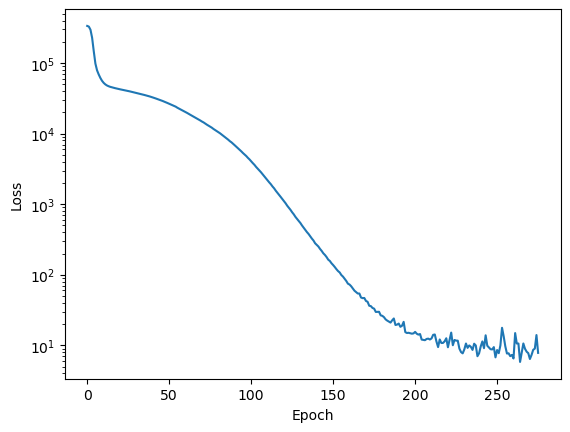

In [54]:
from sklearn.neural_network import MLPRegressor


mlp = MLPRegressor(
    hidden_layer_sizes=(100, 100), 
    activation='relu', 
    solver='adam', 
    learning_rate='constant',
    learning_rate_init=0.001, 
    max_iter=1000, 
    random_state=0, 
    batch_size=32
)


X_train, X_test, y_train, y_test = dataset.X_train, dataset.X_test, dataset.y_train, dataset.y_test

mlp.fit(X_train, y_train)

## Score
print("R^2 score: %f" % mlp.score(X_test, y_test))

plt.semilogy(mlp.loss_curve_)
plt.xlabel('Epoch')
plt.ylabel('Loss')

We can see how changing the batch size affects the training process.

Batch size: 2, loss: 165.431
Training score: 0.997, Test score: 0.996
Batch size: 32, loss: 7.805
Training score: 1.000, Test score: 1.000
Batch size: 512, loss: 79.069
Training score: 0.999, Test score: 0.997


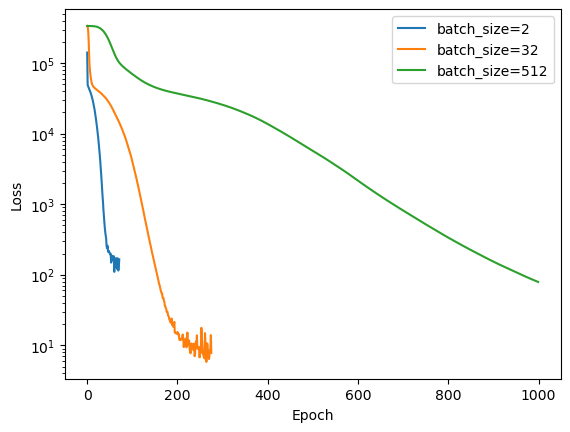

In [55]:
for batch_size_value in [2, 32, 512]:
    mlp = MLPRegressor(
        hidden_layer_sizes=(100, 100), 
        activation='relu', 
        solver='adam', 
        learning_rate='constant',
        learning_rate_init=0.001, 
        max_iter=1000, 
        random_state=0, 
        batch_size=batch_size_value
    )

    mlp.fit(X_train, y_train)
    plt.semilogy(mlp.loss_curve_, label=f"batch_size={batch_size_value}")

    print(f"Batch size: {batch_size_value}, loss: {mlp.loss_curve_[-1]:.3f}")
    print(f"Training score: {mlp.score(X_train, y_train):.3f}, Test score: {mlp.score(X_test, y_test):.3f}")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

Learning rate: 1.0, loss: 2585.326
Training score: 0.970, Test score: 0.961
Learning rate: 0.1, loss: 781.818
Training score: 0.996, Test score: 0.995
Learning rate: 0.001, loss: 7.805
Training score: 1.000, Test score: 1.000
Learning rate: 1e-05, loss: 75985.939
Training score: -0.328, Test score: -0.516


Text(0, 0.5, 'Loss')

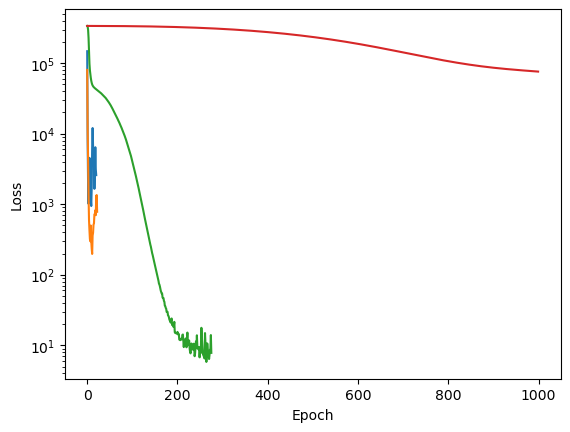

In [56]:
for lr in [1e0, 1e-1, 1e-3, 1e-5]:
    mlp = MLPRegressor(hidden_layer_sizes=(100, 100), 
                       activation='relu', 
                       solver='adam', 
                       learning_rate='constant',
                       learning_rate_init=lr, 
                       max_iter=1000, 
                       random_state=0,
                       batch_size=32)

    mlp.fit(X_train, y_train)
    plt.semilogy(mlp.loss_curve_, label=f"learning_rate={lr}")

    print(f"Learning rate: {lr}, loss: {mlp.loss_curve_[-1]:.3f}")
    print(f"Training score: {mlp.score(X_train, y_train):.3f}, Test score: {mlp.score(X_test, y_test):.3f}")
plt.xlabel('Epoch')
plt.ylabel('Loss')